# SP 9, "Mass Cash": Problem 3

The "Mass Cash" lottery randomly chooses $5$ of the numbers from $1, 2, ..., 35$ each day (without repeitions within the choice of $5$ numbers). Suppose that we want to know how long it will take until all numbers have been chosen.

Let $a_{j}$ be the average number of _additional_ days needed if we are missing $j$ numbers (so $a_{0} = 0$ and $a_{35}$ is the average number of days needed to collect all $35$ numbers). Find a recursive formula for the $a_{j}$'s.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [2]:
# Import dependencies
import random
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from math import floor, ceil, factorial, comb

## Empirical Solution 

In [3]:
def sim_mass_cash(balls: tuple, unused_balls: set, days: int = 0) -> int:
    """
    Simulation counting the number of days required to have appearance of each ball
    at least once given each day's draw consists of 5 balls without replacement
    
    Implemented using recursion
    """
    
    # Base case
    if len(unused_balls) == 0:
        return days
    
    # Recursive case
    else:
        draw = set(random.sample(balls, 5))
        unused_balls -= draw
        days += 1
        return sim_mass_cash(balls, unused_balls, days)

In [4]:
def sim_mass_cash_iterate(balls: tuple, unused_balls: set) -> int:
    """
    Simulation counting the number of days required to have appearance of each ball
    at least once given each day's draw consists of 5 balls without replacement
    
    Implemented using iteration
    """
    days = 0
    while unused_balls:
        draw = set(random.sample(balls, 5))
        unused_balls -= draw
        days += 1

    return days    

In [5]:
# Mass Cash numbered balls
balls = tuple(x for x in range(1, 35+1))

# Run simulation lots of times and average
N = 50_000
trial_data = np.array([sim_mass_cash_iterate(balls, set(balls)) for _ in range(N)])

Running the simulation yields the following estimate for $a_{35}$:

In [6]:
# Average number of days needed to collect all 35 numbers
trial_data.mean()

27.75198

Let's construct a plot for all $a_{j}$!

In [7]:
# Generate data
data = OrderedDict()
unused_balls = list(balls)
while len(data) < 35:
    data[len(unused_balls)] = np.array([sim_mass_cash_iterate(balls, set(unused_balls)) for _ in range(N)]).mean()
    unused_balls.pop()

# Add base case
data[0] = 0.0

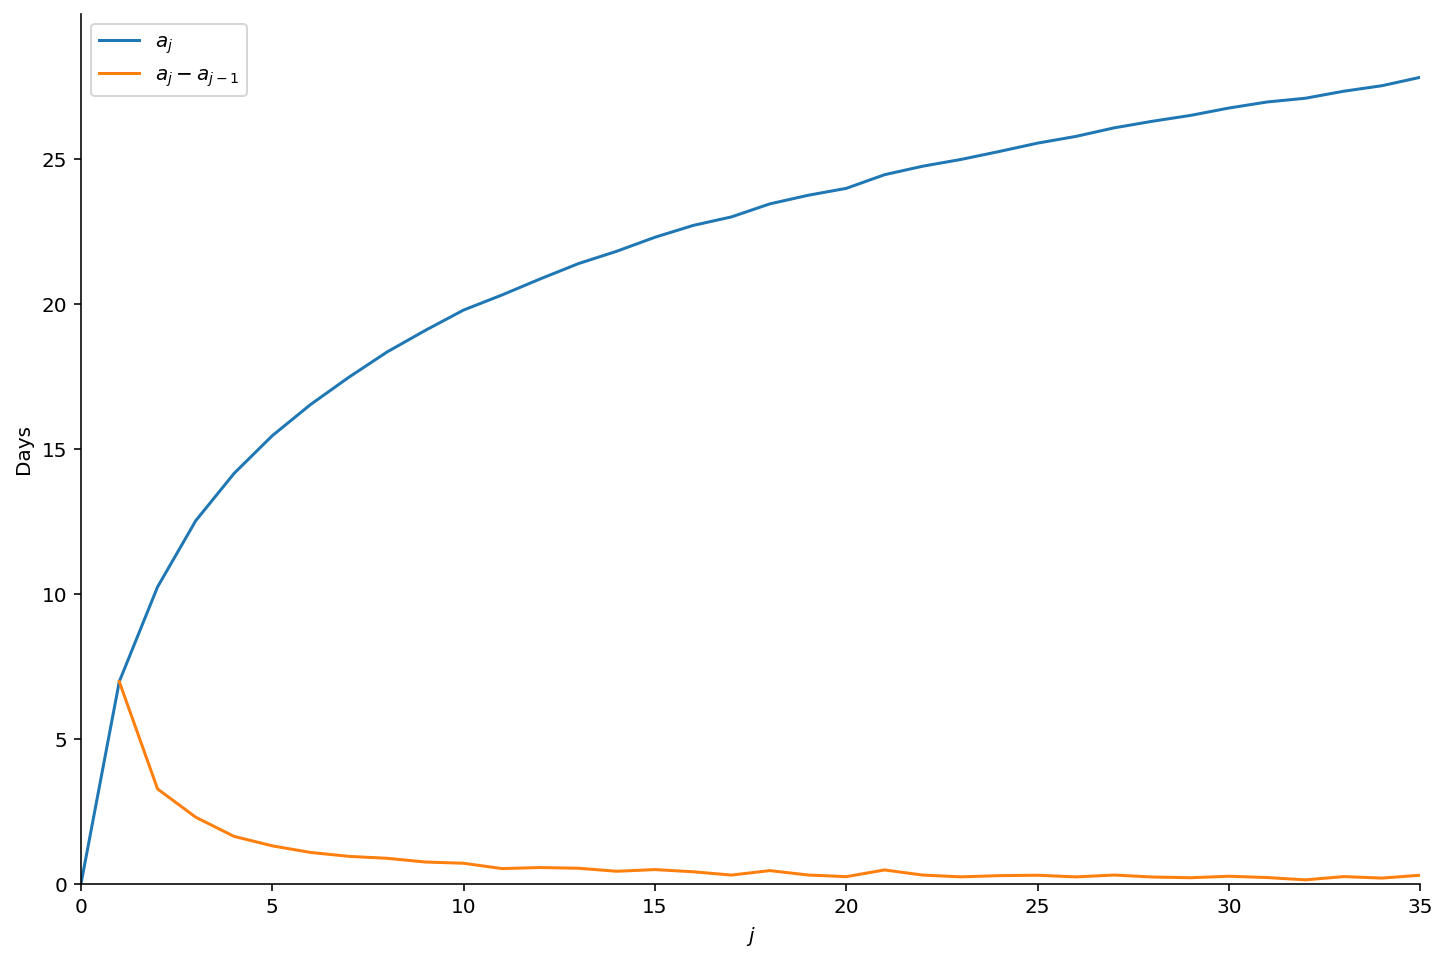

In [18]:
# Gather data
df = pd.DataFrame.from_dict(data, orient='index', columns=['exp_days'])
df['delta'] = df['exp_days'] - df['exp_days'].shift(-1)

# Plot data
plt.figure(figsize=(12,8))
plt.plot(df['exp_days'], label='$a_j$')
plt.plot(df['delta'], label=r'$a_j - a_{j-1}$')

# Cosmetic adjustments
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim(0, 35)
plt.xlabel('$j$')
plt.ylim(0, 30)
plt.ylabel('Days')
plt.yticks(np.arange(0, ceil(df['exp_days'].max()), 5.0))
plt.legend()

plt.show()

## Analytical Solution 

Notice that $a_{1} = E(A_{1})$ where $A_{1} \sim \text{FS}(p)$ and $p$ is the probability the last remaining ball is drawn in the daily lotto drawing. This means that $p = \frac{1}{7} \implies E(A_{1}) = 7$ by symmetry because all arrangements of 35 balls are equally likely and the missing one has $5(\frac{1}{35}) = \frac{1}{7}$ probability of being among the first 5 drawn. This is confirmed by the simulation above.

$a_{2}$ is a little trickier because there are three events to condition on:

1. the **lower-numbered** remaining ball is drawn first on one day and the **higher-numbered** remaining ball is drawn second on a subsequent day
2. the **higher-numbered** remaining ball is drawn first on one day and the **lower-numbered** remaining ball is drawn second on a subsequent day
3. **both** remaining balls are drawn together on the **same day**

This isn't quite right, but I get the feeling it's close...see the empirical results below.

In [23]:
# p = P(high number OR low number)
p_low = p_high = comb(5,1) * factorial(34) / factorial(35)
p_high_and_low = comb(5,2) * factorial(33) / factorial(35)
p_low_or_high = p_high + p_low - p_high_and_low

# E(X), X ~ FS(p)
1 + (1 - p_low_or_high) / p_low_or_high

3.5

In [24]:
df.loc[2:, :]

,exp_days,delta
2,10.23272,3.26514
1,6.96758,6.96758
0,0.00000,NaN
